In [2]:
%matplotlib inline
import numpy as np
import os
from models.cProGAN import Generator
import torch
from dataset import CustomDataset
from dataset_splitter import DatasetSplitter
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
from feature_extractors.mri.mri_improvement import get_current_border_position

In [3]:
def get_mean_std(train_dataset):
    loader = DataLoader(train_dataset, batch_size=len(train_dataset))
    data = next(iter(loader))
    
    heat = data["heat"].mean(), data["heat"].std()
    coil = data["coil"].mean(), data["coil"].std()
    us = data["us_wave"].mean(), data["us_wave"].std()

    return heat, coil, us

In [4]:

def generate_fake_images(data, G, device):
    dataloader = DataLoader(data, batch_size=10, shuffle=False, pin_memory=True)

    fake_to_return = []
    real_to_return = []
    us = []
    coil = []
    heat = []
    for data in dataloader:
        mr_batch = data["mr"].to(device)
        wave_batch = None
        us_wave_batch = data["us_wave"].to(device)
        coil_batch = data["coil"].to(device)
        heat_batch = data["heat"].to(device)
        us_raw_batch = None

        noise_batch = torch.randn(mr_batch.shape[0], 256-32, 1, 1, device=device)
        fake_batch = G(noise_batch, wave_batch, us_wave_batch, coil_batch, heat_batch, us_raw_batch, 5, 1)

        fake_to_return.extend(np.uint8((fake_batch[:, 0, :, :].detach().cpu().numpy()+1)/2*255))
        real_to_return.extend(np.uint8((mr_batch.detach().cpu().numpy()+1)/2*255))
        us.extend(us_wave_batch.detach().cpu().numpy().flatten())
        coil.extend(coil_batch.detach().cpu().numpy().flatten())
        heat.extend(heat_batch.detach().cpu().numpy().flatten())

    return real_to_return, fake_to_return, us, coil, heat

In [6]:

def track_border(real, fake, threshold, x, show=False):    
    real_waveform, fake_waveform = [], []
    for r, f in zip(real, fake):
        y_real, mask_real = get_current_border_position(r, threshold, x)
        y_fake, mask_fake = get_current_border_position(f, threshold, x)

        real_waveform.append(y_real)
        fake_waveform.append(y_fake)

        if show:
            img = np.concatenate([mask_real, mask_fake], axis=1)
            cv2.imshow("Frame", img)
            cv2.waitKey(200)
    
    return np.array(real_waveform), np.array(fake_waveform)

In [7]:
runs = {
    "A2": "rose-monkey-196",
    "A3": "lunar-shape-197",
    "B1": "dashing-snow-198",
    "B2": "eager-terrain-199",
    "B3": "giddy-water-200",
    "C1": "visionary-sponge-201",
    "C2": "chocolate-rain-202",
    "C3": "super-snowflake-203",
}

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pattern = "Regular Breathing"
results = {
    "Regular Breathing": {}, 
    "Shallow Breathing": {}, 
    "Deep Breathing": {}, 
    "Deep BH": {}, 
    "Half Exhale BH": {}, 
    "Full Exhale BH": {}
}

for subject in runs.keys():
    data_root = os.path.join("C:", os.sep, "data", "Formatted_datasets")
    dataset = CustomDataset(data_root, subject)
    splitter = DatasetSplitter(dataset, .8, .1, .1)
    train_dataset = splitter.get_train_dataset()
    heat_normalizer, coil_normalizer, us_normalizer = get_mean_std(train_dataset)

    dataset = CustomDataset(data_root, subject, coil_normalizer, heat_normalizer, us_normalizer)
    splitter = DatasetSplitter(dataset, .8, .1, .1)

    model_path = f"C:\\dev\\depth-tests\\GAN\\best_models\\{runs[subject]}.pth"
    G = Generator(
        heat_length=dataset[0]["heat"].shape[0],
        coil_length=dataset[0]["coil"].shape[0],
        us_length=dataset[0]["us_wave"].shape[0],
        layers=[256, 128, 64, 32, 16, 8],
    ).to(device)
    G.load_state_dict(torch.load(model_path))
    G.eval()

    for pattern in results.keys():
        data = splitter.test_subsets[pattern]
        real, fake, us, coil, heat = generate_fake_images(data, G, device)

        threshold = dataset.settings["MRI"]["Updated_Waveform_parameters"]["Threshold"]
        x = dataset.settings["MRI"]["Updated_Waveform_parameters"]["x"]

        real_waveform, fake_waveform = track_border(real, fake, threshold, x-32)

        results[pattern][subject] = {"real": real_waveform, "fake": fake_waveform, "mae": np.abs(real_waveform - fake_waveform)}

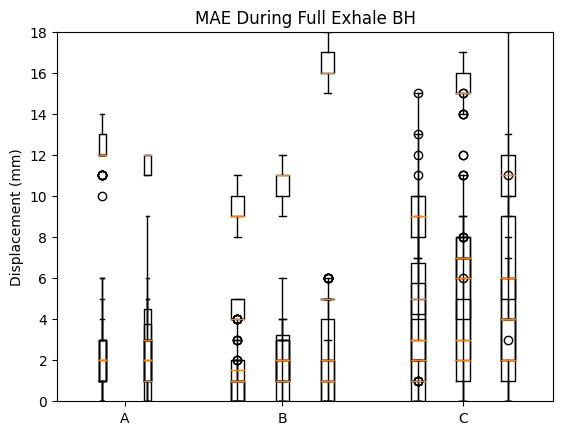

In [13]:
for pattern in ["Regular Breathing", "Shallow Breathing", "Deep Breathing", "Deep BH", "Half Exhale BH", "Full Exhale BH"]:
    A = [results[pattern]["A2"]["mae"], results[pattern]["A3"]["mae"]]
    B = [results[pattern]["B1"]["mae"], results[pattern]["B2"]["mae"], results[pattern]["B3"]["mae"]]
    C = [results[pattern]["C1"]["mae"], results[pattern]["C2"]["mae"], results[pattern]["C3"]["mae"]]

    plt.boxplot(A, positions=[1, 2])
    plt.boxplot(B, positions=[4, 5, 6])
    plt.boxplot(C, positions=[8, 9, 10])

    plt.title(f"MAE During {pattern}")
    plt.ylabel("Displacement (mm)")
    plt.xlim(0,11)
    plt.ylim(0, 18)
    plt.xticks(labels=["A", "B", "C"], ticks=[1.5, 5, 9])
    plt.show()


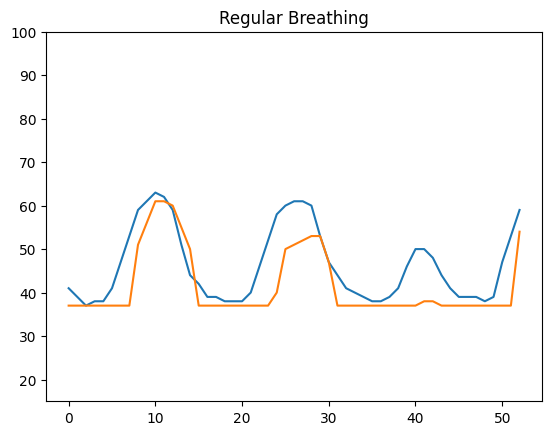

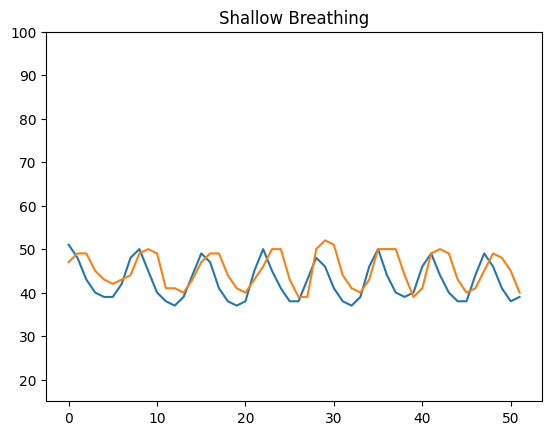

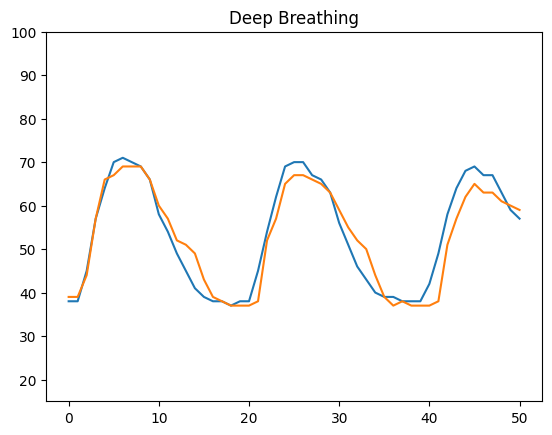

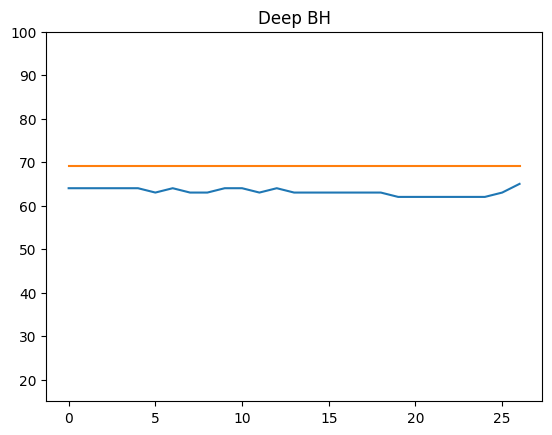

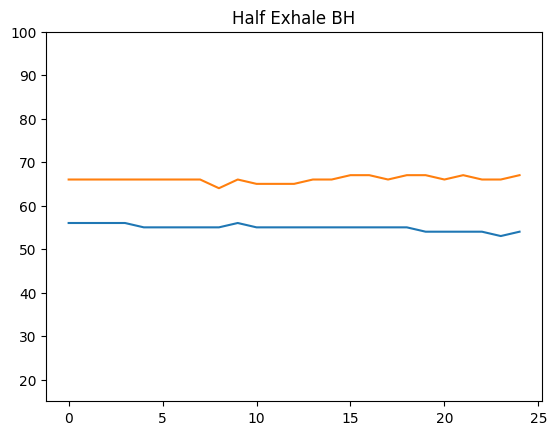

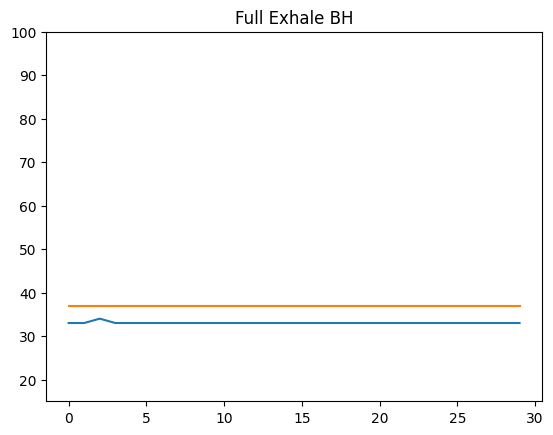

In [30]:
subject = "C3"

for pattern in results.keys():
    real = results[pattern][subject]["real"]
    fake = results[pattern][subject]["fake"]
    plt.figure()
    plt.title(pattern)
    plt.plot(real)
    plt.plot(fake)
    plt.ylim(15, 100)
    plt.savefig(f"temp/{pattern}.png")

In [50]:
for pattern in ["Regular Breathing", "Shallow Breathing", "Deep Breathing", "Deep BH", "Half Exhale BH", "Full Exhale BH"]:
    data = splitter.test_subsets[pattern]
    real, fake, us, coil, heat = generate_fake_images(data, G, device)
    threshold = dataset.settings["MRI"]["Updated_Waveform_parameters"]["Threshold"]
    x = dataset.settings["MRI"]["Updated_Waveform_parameters"]["x"]

    real_waveform, fake_waveform = track_border(real, fake, threshold, x-32)

    plt.figure()
    plt.plot(real_waveform, label="Real")
    plt.plot(fake_waveform, label="Fake")
    plt.ylim([50, 150])
    plt.title(f"Liver movement for {pattern}")
    plt.ylabel("Displacement (mm)")
    plt.xlabel("Frame number")
    plt.legend()
    plt.show()

In [14]:
results.keys()

dict_keys(['Regular Breathing', 'Shallow Breathing', 'Deep Breathing', 'Deep BH', 'Half Exhale BH', 'Full Exhale BH'])

In [89]:
for subject in results.keys():
    real = results[subject]["real"]
    fake = results[subject]["fake"]
    plt.title(subject)
    plt.plot(real)
    plt.plot(fake)
    plt.show()

In [88]:
mae = []
for subject in results.keys():
    mae.extend(results[subject]["mae"])

mae = np.array(mae)
mae.mean(), mae.std()

(5.554567901234569, 5.826534461035679)

In [32]:
# test_idxs = idxs[val_split:]

a = np.arange(10)

a[5:]

array([5, 6, 7, 8, 9])